<a href="https://colab.research.google.com/github/prog815/progOrder/blob/main/%D1%81_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BC%D0%BE%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек

In [ ]:
! pip install finam-export
! pip install git+https://github.com/prog815/progGA
! pip install git+https://github.com/prog815/progOrder

  Cloning https://github.com/prog815/progGA to /tmp/pip-req-build-2kyqdxdb
  Running command git clone -q https://github.com/prog815/progGA /tmp/pip-req-build-2kyqdxdb
  Created wheel for progGA: filename=progGA-0.0.7-cp36-none-any.whl size=3732 sha256=d0840d5ff3c7c5c195ff54962c667dee8d039c67e4d2a2abe4f0c8afa4a3a75d
  Stored in directory: /tmp/pip-ephem-wheel-cache-n9uw3aqu/wheels/9c/7a/cc/d1ffa9ccaa42befda21d63d0e01c942a0add5854c37e0bd2ff
Successfully built progGA
  Cloning https://github.com/prog815/progOrder to /tmp/pip-req-build-_p4etued
  Running command git clone -q https://github.com/prog815/progOrder /tmp/pip-req-build-_p4etued
  Created wheel for progOrder: filename=progOrder-0.0.3-cp36-none-any.whl size=2381 sha256=0857ec85699b86ca6ac1023a0ff0c0f8c80af52b0b9493802d610fedf9c22edd
  Stored in directory: /tmp/pip-ephem-wheel-cache-mhu68ui9/wheels/55/73/64/80cff258e67e5c7a4b92084f656d1e4f2f48a7543da44468f2
Successfully built progOrder


In [ ]:
from finam import Exporter, Market
import datetime
import pandas as pd
import numpy as np
import seaborn as snb
import matplotlib.pyplot as plt
from progGA import ListGenetic
from progOrder import getBuySellForData
import pickle
import os
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

# Загрузка данных

In [ ]:
exporter = Exporter()
sber = exporter.lookup(code='SBER', market=Market.SHARES)
data = exporter.download(sber.index[0],market=Market.SHARES,start_date=datetime.date(2008, 1, 1))
data.drop('<TIME>',axis=1,inplace=True)
data.set_index('<DATE>',inplace=True)
data.set_index(pd.to_datetime(data.index,format='%Y%m%d'),inplace=True)
data

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
<DATE>,,,,,
2008-01-09,101.99,103.70,100.72,101.85,32124562
2008-01-10,102.07,103.81,101.53,103.53,39745084
2008-01-11,103.60,105.45,102.86,104.70,32814608
2008-01-14,104.28,105.30,104.20,105.00,20709850
2008-01-15,105.20,106.60,104.80,105.71,51441473
...,...,...,...,...,...
2020-12-22,259.55,267.42,257.05,262.04,105345250
2020-12-23,262.20,270.29,260.22,270.10,67880370
2020-12-24,271.90,272.82,267.13,269.32,42447420


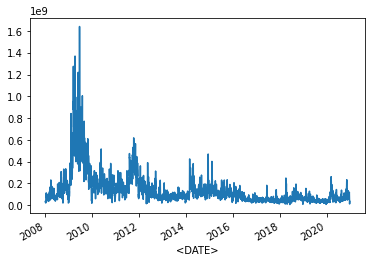

In [ ]:
data['<VOL>'].plot()

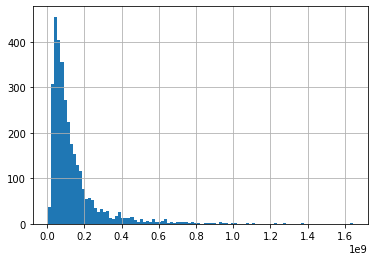

In [ ]:
data['<VOL>'].hist(bins=100)

In [ ]:
ohlcv = data.values[:,:5]
d_ohlcv = np.array(ohlcv)
for n in range(1,len(ohlcv)):
    b = ohlcv[n-1,3]
    d_ohlcv[n,:] = (ohlcv[n,:] - b) / b
d_ohlcv[0,:] = np.nan

data['dOpen'] = d_ohlcv[:,0]
data['dHigh'] = d_ohlcv[:,1]
data['dLow'] = d_ohlcv[:,2]
data['dClose'] = d_ohlcv[:,3]

data

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,dOpen,dHigh,dLow,dClose
<DATE>,,,,,,,,,
2008-01-09,101.99,103.70,100.72,101.85,32124562,NaN,NaN,NaN,NaN
2008-01-10,102.07,103.81,101.53,103.53,39745084,0.002160,0.019244,-0.003142,0.016495
2008-01-11,103.60,105.45,102.86,104.70,32814608,0.000676,0.018545,-0.006472,0.011301
2008-01-14,104.28,105.30,104.20,105.00,20709850,-0.004011,0.005731,-0.004776,0.002865
2008-01-15,105.20,106.60,104.80,105.71,51441473,0.001905,0.015238,-0.001905,0.006762
...,...,...,...,...,...,...,...,...,...
2020-12-22,259.55,267.42,257.05,262.04,105345250,-0.008556,0.021506,-0.018106,0.000955
2020-12-23,262.20,270.29,260.22,270.10,67880370,0.000611,0.031484,-0.006946,0.030759
2020-12-24,271.90,272.82,267.13,269.32,42447420,0.006664,0.010070,-0.010996,-0.002888


# Поиск гиперпараметров

## Целевая функция

In [ ]:
%%time

from sklearn.metrics import confusion_matrix,f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier

valLen = 0.2        # глубина/доля валидации для генетики
orderLifeLen = 50   # срок жизни ордера



def getQualityMethod(lookback,     # окно задержки
                     max_depth,    # максимальная глубина дерева
                     n_estimators, # кол-во эстиматоров
                     dTP,          # тейк-профит
                     dSL):         # стоплос
                     
    # подготовка сигналов
    b,s = getBuySellForData(ohlcv[:,:-1],orderLifeLen=orderLifeLen,dSL=dSL,dTP=dTP)

    # подготовка входов
    X = np.hstack([data[['dOpen','dHigh','dLow','dClose','<VOL>']].shift(n) for n in range(lookback)])
    # y = np.vstack([b,s]).T
    y = b*2+s

    # отбор реальных значений
    idx = ~np.any(np.isnan(X),axis=1)
    X = X[idx]
    y = y[idx]

    # разделение выборок
    try:
        X_learn, X_valid, y_learn, y_valid = train_test_split(X,y,shuffle=True,test_size=valLen,stratify=y)
    except Exception:
        return -dSL
    
    # нормализация
    # sModel = StandardScaler()
    # sModel.fit(X_learn)

    # X_learn = sModel.transform(X_learn)
    # X_valid = sModel.transform(X_valid)

    # создание модели

    model = RandomForestClassifier(max_depth=max_depth,class_weight='balanced',n_estimators=n_estimators)

    # обучение модели

    model.fit(X_learn, y_learn)

    # возвращаем точности на отборе генетики
    
    # print(model.evaluate(X_valid,y_valid))
    pred_valid = model.predict(X_valid)
    # print(np.mean(pred_valid,axis=0),np.std(pred_valid,axis=0))
    # print('pred_valid',np.unique(pred_valid,return_counts=True))
    # print('y_valid',np.unique(y_valid,return_counts=True))

    # print(confusion_matrix(y_valid,pred_valid))
    # print(classification_report(y_valid,pred_valid))
    
    # raise Exception(1)

    def y2bs(y):
        s = y % 2
        b = ( y - s ) // 2
        return b,s

    num2bs = lambda num : np.array([[b,s] for b,s in zip(*y2bs(num))])
    
    def kach(PR,TR):
        return np.mean(PR*(TR*dTP-(1-TR)*dSL))

    res = kach(num2bs(pred_valid),num2bs(y_valid))

    if res == 0.0:  # не нужны тупые бездействующие модели
        res = -dSL*2.0

    return res

res = getQualityMethod(30,7,200,0.004,0.01)
print(res)

-0.0014914728682170542
CPU times: user 3.46 s, sys: 31.8 ms, total: 3.49 s
Wall time: 3.66 s


## Создание модели

### Создание

In [ ]:
modelGA = ListGenetic(pop_size = 200,
                      lookback = range(10,300),
                      max_depth = range(2,100),
                      n_estimators = range(10,500),
                      dTP = np.round(np.arange(0.0001,0.01,0.0001),4),
                      dSL = np.round(np.arange(0.0001,0.01,0.0001),4),
                      quality_method=getQualityMethod)

### или загрузка с диска

In [ ]:
fn = '/content/drive/My Drive/prog/model_so_26.12.2020.pkl'

if os.path.exists(fn):
    with open(fn,'rb') as fp:
        modelGA = pickle.load(fp)

## Бесконечный цикл обучения

In [ ]:
import logging
logging.getLogger('tensorflow').disabled = True

while True:
    modelGA.fit(10,echo_time=60)
    with open(fn,'wb') as fp:
        pickle.dump(modelGA,fp)

5264 {'quality': -3.170731707317073e-06, 'lookback': 181, 'max_depth': 55, 'n_estimators': 428, 'dTP': 0.0053, 'dSL': 0.0066}
5268 {'quality': -3.284072249589491e-06, 'lookback': 210, 'max_depth': 49, 'n_estimators': 337, 'dTP': 0.0048, 'dSL': 0.0068}
5271 {'quality': -7.303370786516854e-06, 'lookback': 140, 'max_depth': 57, 'n_estimators': 333, 'dTP': 0.0055, 'dSL': 0.0067}
finish -  5271 {'quality': -7.303370786516854e-06, 'lookback': 140, 'max_depth': 57, 'n_estimators': 333, 'dTP': 0.0055, 'dSL': 0.0067}
5275 {'quality': -1.905537459283388e-05, 'lookback': 188, 'max_depth': 55, 'n_estimators': 429, 'dTP': 0.0058, 'dSL': 0.007}
5279 {'quality': 7.434640522875817e-06, 'lookback': 196, 'max_depth': 58, 'n_estimators': 332, 'dTP': 0.0059, 'dSL': 0.0068}
finish -  5281 {'quality': -0.013, 'lookback': 213, 'max_depth': 58, 'n_estimators': 327, 'dTP': 0.0053, 'dSL': 0.0065}
5285 {'quality': 8.019639934533552e-06, 'lookback': 200, 'max_depth': 58, 'n_estimators': 318, 'dTP': 0.0049, 'dSL':

KeyboardInterrupt: ignored

## Графики

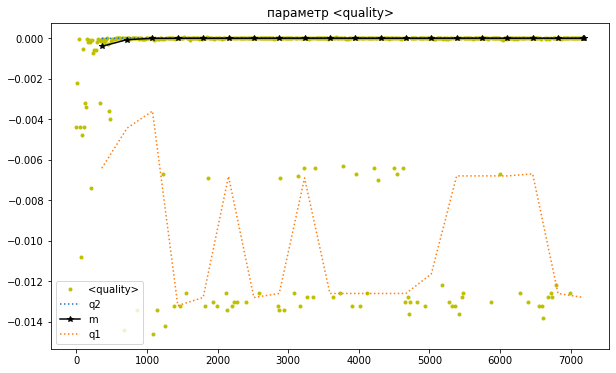

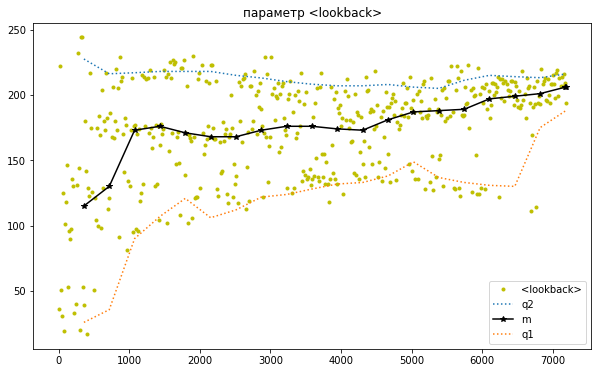

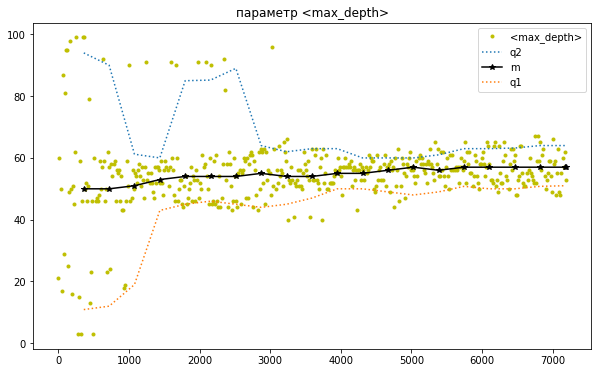

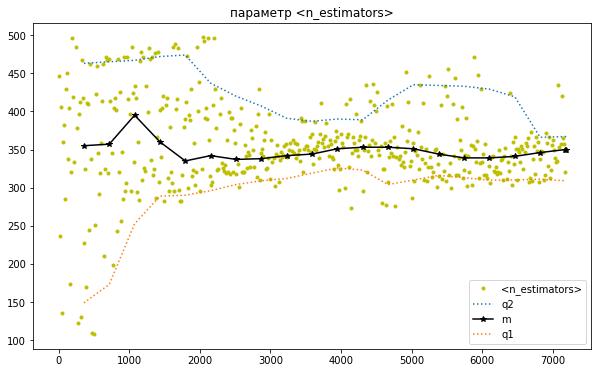

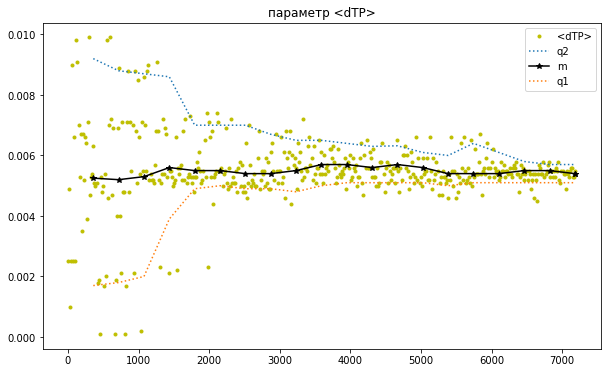

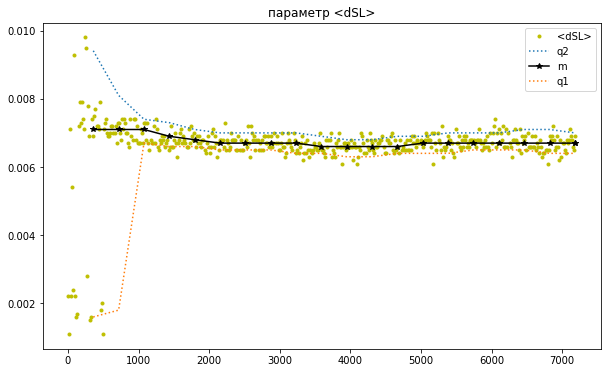

In [ ]:
modelGA.plot_hist_new(('quality','lookback','max_depth','n_estimators','dTP','dSL'))

In [ ]:
for n,h in enumerate(modelGA._hist):
    if h['new']['quality'] > 0:
        print(n,h['new'])


18 {'quality': 9.259259259259259e-06, 'lookback': 15, 'max_depth': 58, 'n_estimators': 415, 'dTP': 0.0055, 'dSL': 0.006}
35 {'quality': 1.9778481012658216e-06, 'lookback': 96, 'max_depth': 50, 'n_estimators': 408, 'dTP': 0.0096, 'dSL': 0.0071}
69 {'quality': 2.9626749611197504e-05, 'lookback': 41, 'max_depth': 49, 'n_estimators': 404, 'dTP': 0.0068, 'dSL': 0.0073}
191 {'quality': 7.131280388978931e-06, 'lookback': 170, 'max_depth': 52, 'n_estimators': 455, 'dTP': 0.0088, 'dSL': 0.0072}
201 {'quality': 7.476635514018691e-06, 'lookback': 45, 'max_depth': 21, 'n_estimators': 233, 'dTP': 0.0092, 'dSL': 0.0068}
203 {'quality': 1.1155063291139244e-05, 'lookback': 95, 'max_depth': 44, 'n_estimators': 274, 'dTP': 0.0051, 'dSL': 0.007}
266 {'quality': 6.907894736842105e-06, 'lookback': 213, 'max_depth': 18, 'n_estimators': 454, 'dTP': 0.0049, 'dSL': 0.007}
291 {'quality': 1.5280000000000006e-05, 'lookback': 128, 'max_depth': 97, 'n_estimators': 466, 'dTP': 0.0041, 'dSL': 0.0073}
303 {'quality':

## Параметры лучшей

In [ ]:
best_par = modelGA.getBestParams()
best_par

{'dSL': 0.0067,
 'dTP': 0.0055,
 'lookback': 202,
 'max_depth': 57,
 'n_estimators': 352}